# Measure and Optimize Comparer queries - Prolific Data
@ ishapira, 10/23


**Objective:** Evaluate if an LLM can correctly identify the higher approval rate among two options based on human experiment data.



## Data Loading and Preprocessing
### Data Loading


In [31]:
# **Import necessary libraries**
import numpy as np
import pandas as pd
import seaborn as sns
import itertools

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import re
from generative_social_choice.objects.comparers import BasicComparer
from utils.gpt_wrapper import  prompt_gpt
from tqdm import tqdm
from generative_social_choice.datasets.datasets import get_dataset
from generative_social_choice.experiments.prolific_approval_query_eval.create_agents import (
    extract_statement_from_question,
)


In [32]:
# load raw data
dataset = get_dataset("prolific")
experiment_name = 'chatbot_personalization_eval_23_09_28_strict'
agent_ids = dataset.get_agent_ids()[experiment_name]
df = dataset.load()

### Data Transformation


In [33]:
def extract_content(q):
    match = re.search(r'"(.*?)"', q)
    return match.group(1) if match else None

def clean_data(df, experiment_name, steps_to_include = [7,9, 11, 13, 15, 17, 19]):
    """
    Filters a dataframe based on experiment_name and specific steps,
    and extracts content from the 'question_text' column.

    Parameters:
    - df (pd.DataFrame): The input dataframe with experiment data.
    - experiment_name (str): The name of the experiment to filter on.

    Returns:
    - pd.DataFrame: A filtered dataframe with an added 'statement' column.

    Columns in the dataframe:
    ['experiment_name', 'user_id', 'step', 'question_type', 'question_text',
     'button_label', 'json_choices', 'time_stamp_question', 'choice', 'text',
     'time_stamp_answer', 'question_text_parsed']
    """

    # Filter based on experiment_name
    df_filtered = df[df['experiment_name'] == experiment_name]

    # Filter based on steps
    df_filtered = df_filtered[df_filtered['step'].isin(steps_to_include)]

    # Extract content between first pair of double quotes


    df_filtered['statement'] = df_filtered['question_text'].apply(extract_content)

    return df_filtered
import pandas as pd

def combine_dataframes(pivot_df, center):
    """
    Combine the provided pivot and center dataframes.

    Parameters:
    - pivot_df (pd.DataFrame): A dataframe with user_id as rows, statements as columns, and scores as entries.
    - center (pd.DataFrame): A dataframe with user_id and text columns.

    Returns:
    - pd.DataFrame: A combined dataframe as described.
    """

    # Start with merging the two dataframes based on user_id
    merged_df = center.merge(pivot_df, on='user_id')

    # Create an empty list to store the new data
    new_data = []

    # Loop through each row of merged dataframe
    for _, row in merged_df.iterrows():
        # Get all statements and their scores for the user
        statement_scores = row[pivot_df.columns].to_dict()

        # Get all possible pairs of unique statements
        for (statement_1, score_1), (statement_2, score_2) in itertools.combinations(statement_scores.items(), 2):
            # Determine the closest statement index
            if score_1 > score_2:
                closest_idx = 0
            elif score_1 < score_2:
                closest_idx = 1
            else:
                continue  # Skip if scores are equal

            new_data.append({
                "center_user": row['text'],
                "center_user_id": row['user_id'],
                "statement_1": statement_1,
                "statement_2": statement_2,
                "similarity_1": score_1,
                "similarity_2": score_2,
                "closest_idx": closest_idx
            })

    # Convert list of dictionaries to dataframe
    result_df = pd.DataFrame(new_data)

    # Sort by the absolute difference between similarity scores
    result_df['similarity_difference'] = (result_df['similarity_1'] - result_df['similarity_2']).abs()
    result_df = result_df.sort_values(by='similarity_difference', ascending=False).drop(columns='similarity_difference')

    return result_df


In [34]:
df_clean = clean_data(df, experiment_name)
pivot_df = df_clean[df_clean.step > 7].pivot(index="user_id", columns="statement", values="choice").astype(int)
center = df_clean[df_clean.step == 7][['user_id','text']]
new_df = combine_dataframes(pivot_df, center)

## Visualize

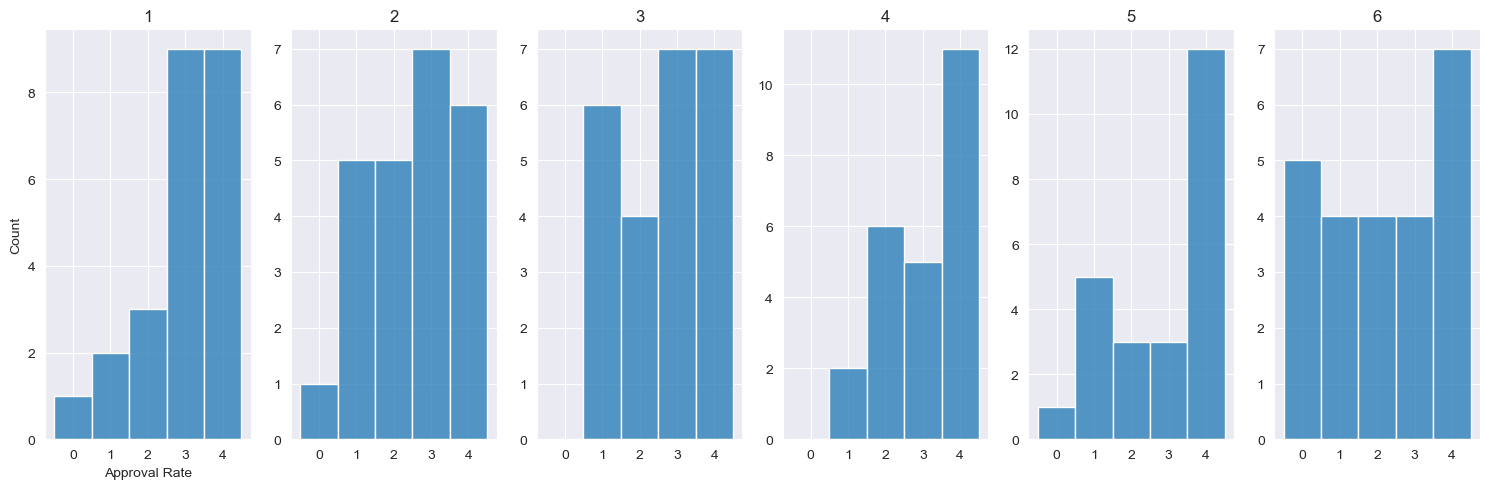

In [81]:
plt.figure(figsize=(15, 5))
for i, column in enumerate(pivot_df.columns, 1):
    plt.subplot(1, 6, i)
    sns.histplot(pivot_df[column], kde=False, bins=np.arange(6) - 0.5)
    plt.title(i)
    plt.xticks(np.arange(5))
    plt.xlabel("Approval Rate" if i == 1 else "")
    plt.ylabel("Count" if i == 1 else "")

plt.tight_layout()
plt.show()

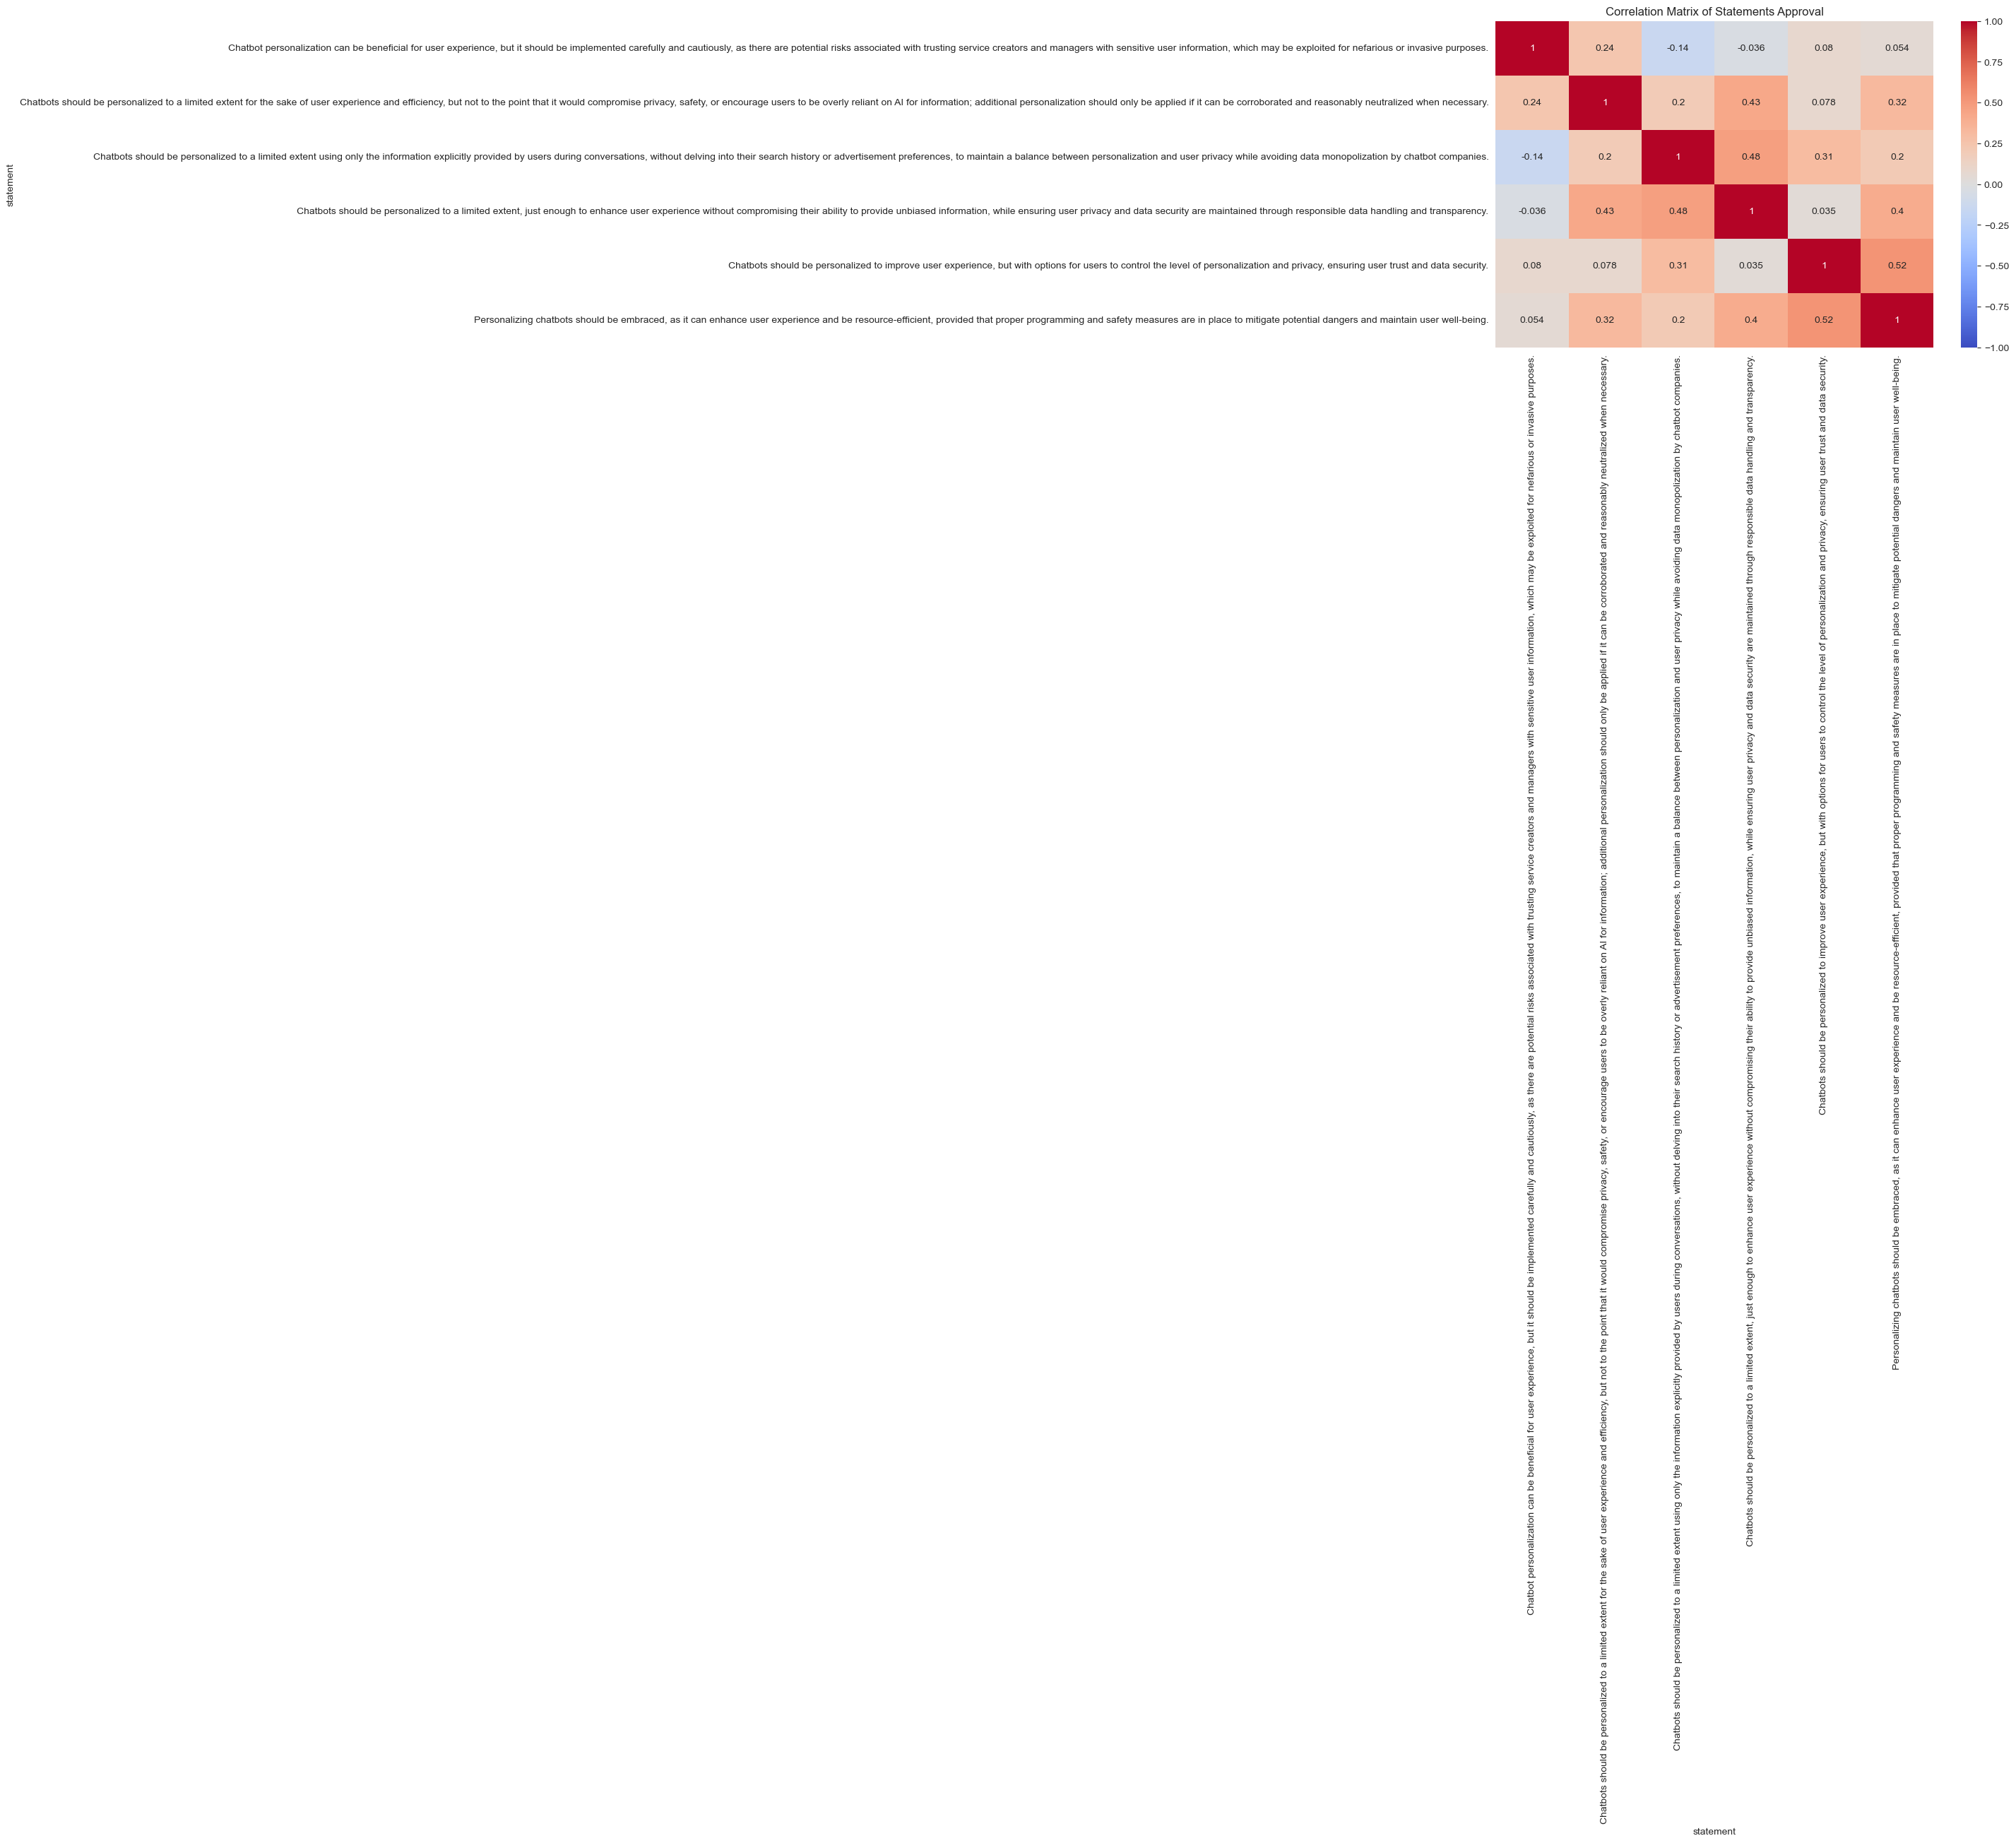

In [82]:
# 2. Heatmap of the Correlation Matrix
correlation_matrix = pivot_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Statements Approval')
plt.show()

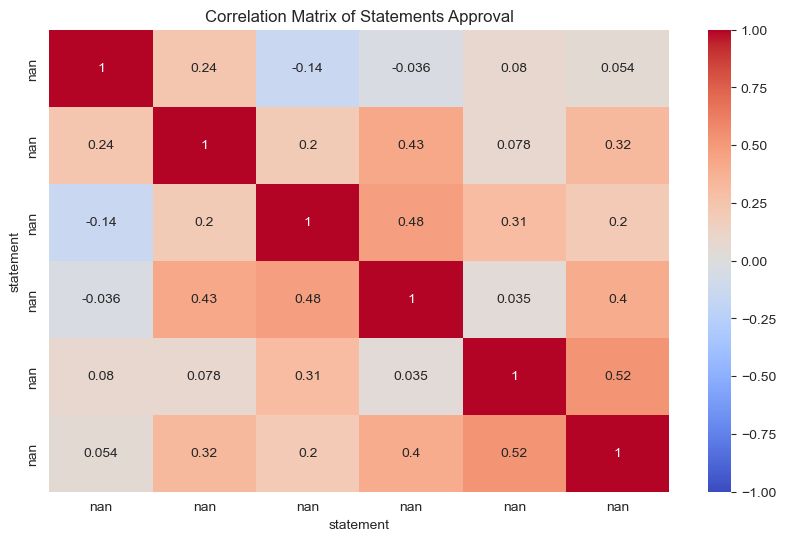

In [85]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            xticklabels=correlation_matrix.columns.str.extract('(\d+)')[0].tolist(),
            yticklabels=correlation_matrix.columns.str.extract('(\d+)')[0].tolist())
plt.title('Correlation Matrix of Statements Approval')
plt.show() # the sorted order is: 0, 2, 3, 4, 1, 5

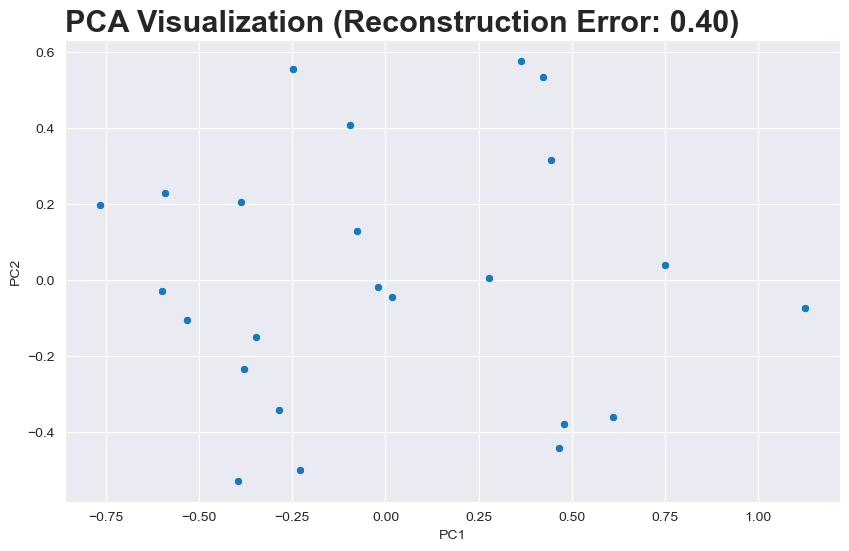

In [123]:
normalized_df = pivot_df / 4
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized_df)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PC1", y="PC2", data=principalDf)


plt.title(f'PCA Visualization (Reconstruction Error: {1 - pca.explained_variance_ratio_.sum():.2f})', loc='left', fontweight='bold', fontsize=22)
plt.show()

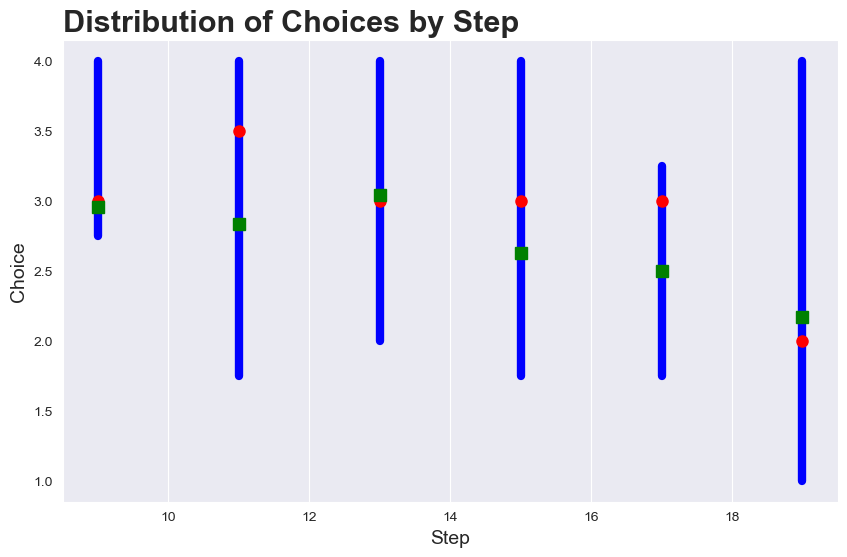

In [122]:
# Group by 'step' and calculate the necessary statistics
grouped = df_clean[['step', 'choice']].astype(float).groupby('step')['choice']
quantiles = grouped.quantile([.25, .5, .75]).unstack()
means = grouped.mean()

plt.figure(figsize=(10, 6))

# Plot the quartiles and means
for step, (q1, median, q3) in quantiles.iterrows():
    plt.plot([step, step], [q1, q3], color='b', linewidth=6)  # IQR box
    plt.plot(step, median, 'ro', markersize=8)  # median
    plt.plot(step, means[step], 'gs', markersize=8)  # mean

# Styling and annotations
plt.title('Distribution of Choices by Step', loc='left', fontweight='bold', fontsize=22)
plt.xlabel('Step', fontsize=14)
plt.ylabel('Choice', fontsize=14)
plt.grid(axis='y')

plt.show()

In [134]:
# the sorted order is: 0, 2, 3, 4, 1, 5 from cautionary to embracing
inx = 0
for j in df_clean.sort_values('step')['statement'].unique():
    print(inx,df_clean[df_clean.statement == j].choice.astype(float).mean(), j)
    inx += 1

0 2.9583333333333335 Chatbot personalization can be beneficial for user experience, but it should be implemented carefully and cautiously, as there are potential risks associated with trusting service creators and managers with sensitive user information, which may be exploited for nefarious or invasive purposes.
1 2.8333333333333335 Chatbots should be personalized to improve user experience, but with options for users to control the level of personalization and privacy, ensuring user trust and data security.
2 3.0416666666666665 Chatbots should be personalized to a limited extent, just enough to enhance user experience without compromising their ability to provide unbiased information, while ensuring user privacy and data security are maintained through responsible data handling and transparency.
3 2.625 Chatbots should be personalized to a limited extent using only the information explicitly provided by users during conversations, without delving into their search history or advertis

### Experiment Setup

In [6]:
def run_experiment_on_prompts(df, model_names, comparer, save_path='results_human.csv', num=5, freq_saving = 1):
    # Step 1: Check if file exists, if so, rename or delete it
    if os.path.exists(save_path):
        os.remove(save_path)  # This line deletes the file. Alternatively, you could rename it.

    prompt_templates = comparer.prompt_templates
    results_data = []
    first_save = True  # Initialize a flag for the first save

    for _ in range(num):
        for model_name in model_names:
            for index, row in tqdm(df.iterrows(), desc=f"{model_name}, run={_}: Processing dataframe rows", total=df.shape[0]):
                for prompt_type, template in prompt_templates.items():
                    center_agent = row['center_user']
                    agent0 = row['statement_1']
                    agent1 = row['statement_2']

                    prompt = template.format(center_agent_description=center_agent,
                                             other_agents_description=f"agent0: {agent0}  \n agent1: {agent1}")

                    response = prompt_gpt(model=model_name, prompt=prompt)

                    try:
                        response_int = int(response)
                        correct = 1 if response_int == row['closest_idx'] else 0
                    except ValueError:
                        correct = -1

                    results_data.append([prompt_type, response, center_agent, agent0, agent1, row['similarity_1'],
                                         row['similarity_2'], row['closest_idx'], correct, model_name, _])

                    if (index + 1) % freq_saving == 0:
                        temp_df = pd.DataFrame(results_data,
                                               columns=['prompt_type', 'response', 'statement_center', 'statement_0',
                                                        'statement_1', 'dist_center_0', 'dist_center_1', 'inx_closes', 'correct', "model_name","inx"])
                        # Step 2: Alter the mode argument based on the first_save flag
                        temp_df.to_csv(save_path, mode='w' if first_save else 'a', header=(first_save or not pd.read_csv(save_path).shape[0]), index=False)
                        first_save = False  # Reset the flag after the first save

    results_df = pd.DataFrame(results_data,
                              columns=['prompt_type', 'response', 'statement_center', 'statement_0',
                                       'statement_1', 'dist_center_0', 'dist_center_1', 'inx_closes', 'correct', 'model_name','run'])
    results_df.to_csv(save_path, index=False)

    return results_df


In [30]:
import os
comparer = BasicComparer(id=0, prompt_type="basic")
results = run_experiment_on_prompts(
    df=new_df,
    model_names=['gpt-4','gpt-3.5-turbo'],
    comparer=comparer,
    save_path='results_prolific.csv',
    num = 5
)

gpt-4, run=1: Processing dataframe rows:  43%|████▎     | 106/247 [1:22:00<2:09:16, 55.01s/it]/var/folders/nj/17y3hdz14jv7skz07226_66c0000gp/T/ipykernel_5260/2476605600.py:37: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df.to_csv(save_path, mode='w' if first_save else 'a', header=(first_save or not pd.read_csv(save_path).shape[0]), index=False)
gpt-3.5-turbo, run=1: Processing dataframe rows:  46%|████▌     | 114/247 [3:42:59<4:20:09, 117.36s/it]


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [85]:
import pandas as pd
from tqdm import tqdm

# Define the statement columns and other columns to load
stmt_columns = ['statement_center', 'statement_0', 'statement_1']
columns_to_load = ['prompt_type', 'response', 'correct', 'model_name', 'dist_center_0', 'dist_center_1']

# Initialize an empty dictionary for the mapping
statement_to_id = {}
last_id = 0

# Define a function to update the mapping dictionary
def update_mapping(chunk_statements, current_mapping, last_id):
    new_statements = set(chunk_statements) - set(current_mapping.keys())
    for stmt in new_statements:
        current_mapping[stmt] = last_id
        last_id += 1
    return current_mapping, last_id

# Read the file in chunks
chunksize = 100_000  # You can adjust this based on available memory
chunks = pd.read_csv("results_prolific.csv", usecols=stmt_columns, chunksize=chunksize)

# Process each chunk for creating mapping
print("Creating statement-to-ID mapping...")
for chunk in tqdm(chunks):
    # Flatten the chunk and get unique statements
    chunk_statements = pd.concat([chunk[col] for col in stmt_columns]).unique()
    # Update the global mapping
    statement_to_id, last_id = update_mapping(chunk_statements, statement_to_id, last_id)

# Now that we have the full mapping, let's read the file again in chunks and replace the statements with their IDs
chunks = pd.read_csv("results_prolific.csv", usecols=columns_to_load + stmt_columns, chunksize=chunksize)

# Create a new file to store the modified results
print("Replacing statements with IDs and saving to file...")
with open("modified_results.csv", "w") as f_out:
    first_chunk = True
    for chunk in tqdm(chunks):
        chunk[stmt_columns] = chunk[stmt_columns].apply(lambda col: col.map(statement_to_id))
        # If it's the first chunk, write headers, otherwise skip headers
        chunk.to_csv(f_out, mode='a', header=first_chunk, index=False)
        first_chunk = False

# Save the mapping to a separate CSV
print("Saving the statement-to-ID mapping to file...")
pd.Series(statement_to_id).reset_index().rename(columns={'index': 'Statement', 0: 'ID'}).to_csv("statement_id_mapping.csv", index=False)


Creating statement-to-ID mapping...


59it [00:34,  1.73it/s]


Replacing statements with IDs and saving to file...


59it [00:39,  1.51it/s]

Saving the statement-to-ID mapping to file...


## Analyze

In [86]:
# # Specify the columns you want to load
# columns_to_load = ['prompt_type', 'correct', 'model_name','dist_center_0', 'dist_center_1']
# res = pd.read_csv("results_prolific.csv", usecols=columns_to_load)
res = pd.read_csv("modified_results.csv")

In [87]:
res.columns

Index(['prompt_type', 'response', 'statement_center', 'statement_0',
       'statement_1', 'dist_center_0', 'dist_center_1', 'correct',
       'model_name'],
      dtype='object')

In [88]:
res['abs_distance'] = (res['dist_center_0'] - res['dist_center_1']).abs()

###  refuse to answer

In [89]:
# Create a new column indicating if 'correct' is -1
res['is_minus_one'] = (res['correct'] == -1).astype(int)

# Create the pivot table
pivot_percentage = res.pivot_table(index='prompt_type',
                                   columns='model_name',
                                   values='is_minus_one',
                                   aggfunc='mean')

# Convert to percentage format
pivot_percentage *= 100

print(pivot_percentage)

model_name      gpt-3.5-turbo     gpt-4
prompt_type                            
CoT                100.000000  3.352661
CoT_w_few_shot       9.422245  0.418646
basic               93.738359  1.719448
few_shot            10.685398  0.460787


### accuracy by prompt

In [90]:
# Create a pivot table
filtered_res = res[(res['correct'] >= 0) & (res['model_name'] == 'gpt-4')]
pivot_table = filtered_res.pivot_table(index='prompt_type', columns='model_name', values='correct', aggfunc='mean')

# Sort by the column "gpt-4"
pivot_table = pivot_table.sort_values(by="gpt-4", ascending=False)

print(pivot_table)


model_name         gpt-4
prompt_type             
basic           0.642972
CoT             0.640704
few_shot        0.634750
CoT_w_few_shot  0.626690


#### Error by distance

In [101]:
# Create the pivot table
pivot = filtered_res.pivot_table(index='prompt_type',
                                 columns='abs_distance',
                                 values='correct',
                                 aggfunc='mean')
# Filter out columns other than 1, 2, 3, 4
pivot = pivot[[1, 2, 3, 4]]

# Sort by the column 4
pivot = pivot.sort_values(by=4, ascending=False)

print(pivot)


abs_distance           1         2         3         4
prompt_type                                           
CoT_w_few_shot  0.591254  0.594327  0.725370  0.773636
CoT             0.589385  0.580511  0.844634  0.748893
basic           0.594680  0.594634  0.830563  0.715160
few_shot        0.595887  0.604066  0.779506  0.665837


### prediction bias

In [93]:
# Assuming filtered_res is already loaded
value_counts = filtered_res['response'].value_counts()

# Calculate percentages
total_responses = len(filtered_res)
percentages = (value_counts / total_responses) * 100

# Create a summary table
summary = pd.DataFrame({'Count': value_counts, 'Percentage (%)': percentages})

print(summary)

     Count  Percentage (%)
0  2160272       57.219276
1  1615155       42.780724


### confusion matrix

In [102]:
# Convert the 'response' column to float type
filtered_res['response'] = filtered_res['response'].astype(float)
# Convert the 'correct' column to float type if it's not
filtered_res['correct'] = filtered_res['correct'].astype(float)

TP = len(filtered_res[(filtered_res['response'] == 1.0) & (filtered_res['correct'] == 1.0)])
TN = len(filtered_res[(filtered_res['response'] == 0.0) & (filtered_res['correct'] == 1.0)])
FP = len(filtered_res[(filtered_res['response'] == 1.0) & (filtered_res['correct'] == 0.0)])
FN = len(filtered_res[(filtered_res['response'] == 0.0) & (filtered_res['correct'] == 0.0)])

confusion_matrix = pd.DataFrame({
    'Predicted 0': [TN, FN],
    'Predicted 1': [FP, TP]
}, index=['Actual 0', 'Actual 1'])

print(confusion_matrix)

/var/folders/nj/17y3hdz14jv7skz07226_66c0000gp/T/ipykernel_5260/256745127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_res['response'] = filtered_res['response'].astype(float)
/var/folders/nj/17y3hdz14jv7skz07226_66c0000gp/T/ipykernel_5260/256745127.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_res['correct'] = filtered_res['correct'].astype(float)


          Predicted 0  Predicted 1
Actual 0      1471964       685090
Actual 1       688308       930065


In [ ]:
    remote: error: File generative_social_choice/demos/modified_results.csv is 490.19 MB; this exceeds GitHub's file size limit of 100.00 MB


In [104]:
res.columns

Index(['prompt_type', 'response', 'statement_center', 'statement_0',
       'statement_1', 'dist_center_0', 'dist_center_1', 'correct',
       'model_name', 'abs_distance', 'is_minus_one'],
      dtype='object')

In [112]:
filtered = filtered_res[filtered_res['model_name'] == "gpt-4"]
target_size_mb = 50
current_size_mb = 490.19 / 3.3
sample_fraction = target_size_mb / current_size_mb
sampled = filtered.sample(frac=sample_fraction)
sampled.to_csv("smaller_modified_results.csv", index=False)